In [1]:
import os
import sys

import peakutils
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

SOURCE_PATH = os.path.abspath(os.getcwd() + '/../../source/')
sys.path.insert(0, SOURCE_PATH)

from geometric import Point, Stright_line, set_mean_line, is_equal_lines
from geometric import get_sorted_extrema, get_sorted_extrema_2, get_trends

from collections import defaultdict

import talib

In [2]:
# x = np.linspace(0, 10, 100)
# y = np.sin(x) + np.random.normal(0, 0.1, len(x))

# thres = 0.95
# peaks1 = peakutils.indexes(y, thres=thres, min_dist=5)
# peaks2 = peakutils.indexes(y * (-1), thres=thres, min_dist=5)

# plt.plot(x, y, label="Сигнал")
# plt.scatter(x[peaks1], y[peaks1], color='green', label="Пики")
# plt.scatter(x[peaks2], y[peaks2], color='red', label="Пики")
# plt.legend()
# plt.show()


In [3]:
# def has_min_two_common_elements(l1, l2):
#     set_l1 = set(l1)
#     common_count = 0
#     for elem in l2:
#         if elem in set_l1:
#             common_count += 1
#             if common_count == 2:
#                 return True
#     return False


# def is_ordered_subset(larger, smaller):
#     if len(l1) > len(l2):
#         it = iter(l1)
#         return all(elem in it for elem in l2)
#     else:
#         it = iter(l2)
#         return all(elem in it for elem in l1)
        

# def is_subset(l1, l2):
#     if len(l1) > len(l2):
#         return set(l2).issubset(l1)
#     else:
#         return set(l1).issubset(l2)

# Data

In [4]:
# Cripto
DATA_PATH = '../../../Parser/data'
f_name = os.path.join(DATA_PATH, 'Crypto/15min', 'btc_usdt.parquet')
df = pd.read_parquet(f_name)
df = df.reset_index(drop=True)

df = df.rename(columns={'volume':'vol'})
# df['big_vol'] = (df['vol'] > df['vol'].rolling(window).median()).map(int)

In [5]:
# df = df.sort_values('datetime').groupby(df['datetime'].dt.date).agg(
#         {
#             'open': 'first',
#             'high': 'max',
#             'low': 'min',
#             'close': 'last',
#             'vol': 'sum',
#         }
#     ).reset_index()

In [6]:
# DATA_PATH = '../data/'
# df = pd.read_csv(
#     os.path.join(DATA_PATH, 'day_preproc', 'SBER'),
#     parse_dates=[0],
#     # date_format='%Y%m%d',
#     # date_parser=lambda x: dt.datetime.strptime(x, '%Y%m%d'),
# )
# df = df[df['mask']==1]
# df = df.reset_index(drop=True)

# df['big_vol'] = (df['vol'] > df['vol'].rolling(window).median()).map(int)

# Extrems: peakutils

In [7]:
def get_extrems(x, y, thres, min_dist, window=100):
    if window < min_dist:
        return None
    
    set_ind = set()
    for i in range(0, len(y)-window, window-min_dist):
        peaks = peakutils.indexes(y[i:i+window], thres=thres, min_dist=min_dist)
        peaks += i
        set_ind.update(x[peaks])

    return np.array(sorted(list(set_ind)))

In [242]:
window = 60
min_dist = 15
thres = 0.5

In [243]:
y = df['close'].values #[100+shift:200+shift].values
x = np.arange(0, len(y))

peaks_max = get_extrems(x, y, thres, min_dist, window=window)
peaks_min = get_extrems(x, y*(-1), thres, min_dist, window=window)

df['extrems'] = 0

df['local_max'] = 0
df.loc[peaks_max, 'local_max'] = 1
df.loc[peaks_max, 'extrems'] = 1

df['local_min'] = 0
df.loc[peaks_min, 'local_min'] = 1
df.loc[peaks_min, 'extrems'] = -1

In [244]:
base_extrems = df[df['extrems']!=0][['extrems','close']]

base_extrems['group'] = base_extrems['extrems'] - base_extrems['extrems'].shift(1)
base_extrems['group'] = base_extrems['group'].fillna(-1)
base_extrems['group'] = base_extrems['group'].abs().cumsum()

base_peaks_max = base_extrems[base_extrems['extrems']==1].groupby('group')['close']\
    .agg(lambda s: s.idxmax()).to_numpy()
base_peaks_min = base_extrems[base_extrems['extrems']==-1].groupby('group')['close']\
    .agg(lambda s: s.idxmin()).to_numpy()

df['base_extrems'] = 0

df['base_local_max'] = 0
df.loc[base_peaks_max, 'base_local_max'] = 1
df.loc[base_peaks_max, 'base_extrems'] = 1

df['base_local_min'] = 0
df.loc[base_peaks_min, 'base_local_min'] = 1
df.loc[base_peaks_min, 'base_extrems'] = -1

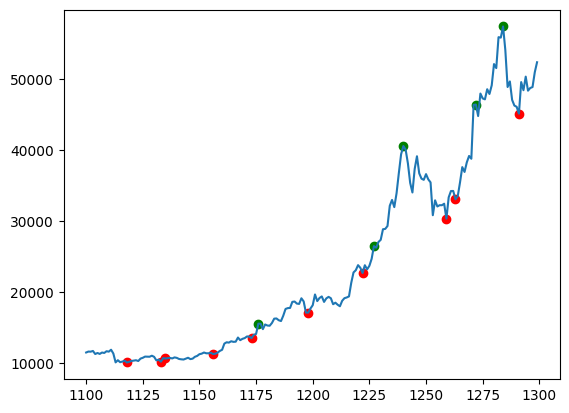

In [245]:
# Визуализация результата

df1 = df[1100:1300]
plt.plot(df1.index, df1['close'], label="Сигнал")
plt.scatter(df1[df1['local_max']==1].index, 
            df1[df1['local_max']==1]['close'], color='green', label="Пики")
plt.scatter(df1[df1['local_min']==1].index, 
            df1[df1['local_min']==1]['close'], color='red', label="Пики")

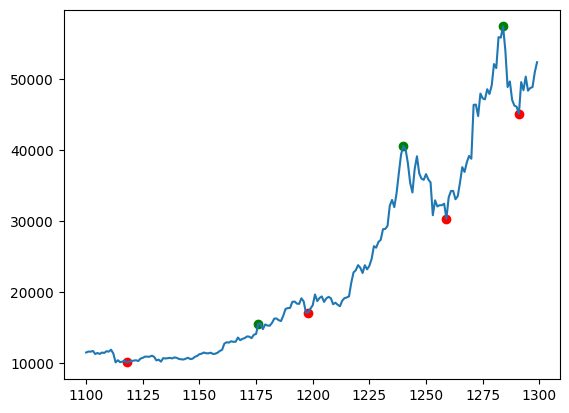

In [246]:
# Визуализация
plt.plot(df1.index, df1['close'], label="Сигнал")
plt.scatter(df1[df1['base_local_max']==1].index, 
            df1[df1['base_local_max']==1]['close'], color='green', label="Пики")
plt.scatter(df1[df1['base_local_min']==1].index, 
            df1[df1['base_local_min']==1]['close'], color='red', label="Пики")

plt.show()

In [156]:
# # Визуализация с объемами
# plt.plot(df1.index, df1['close'], label="Сигнал")
# plt.scatter(df1[(df1['base_local_max']==1) & (df1['big_vol']==1)].index, 
#             df1[(df1['base_local_max']==1) & (df1['big_vol']==1)]['close'], color='green', label="Пики")
# plt.scatter(df1[(df1['base_local_min']==1) & (df1['big_vol']==1)].index, 
#             df1[(df1['base_local_min']==1) & (df1['big_vol']==1)]['close'], color='red', label="Пики")

# plt.show()

# scipy.argrelextrema (лучший способ)

In [5]:
k = 1
y = df[96*k: 96*(k+1)]['close'].values

y_max = df[96*k: 96*(k+1)]['high'].values
y_min = df[96*k: 96*(k+1)]['low'].values

x = np.arange(0,len(y))

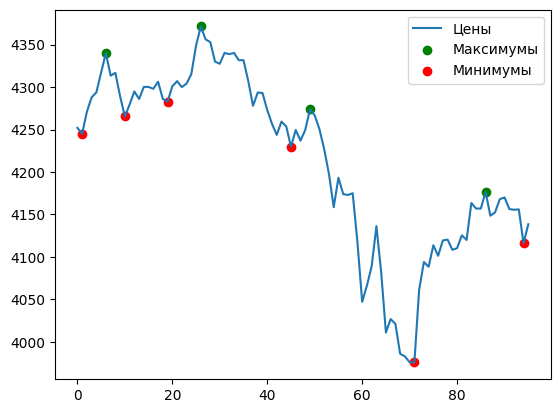

In [6]:
import pandas as pd
from scipy.signal import argrelextrema

# Создаем временной ряд
# data = pd.Series(y)

# Определяем локальные экстремумы
order = 6

local_max = argrelextrema(y, comparator=np.greater, order=order, mode='clip')[0]
local_min = argrelextrema(y, comparator=np.less, order=order, mode='clip')[0]

plt.plot(y, label="Цены")
plt.scatter(local_max, y[local_max], color='g', label="Максимумы")
plt.scatter(local_min, y[local_min], color='r', label="Минимумы")
plt.legend()
plt.show()


In [14]:
trend_period * trend_power

array([-0.00164863,  0.02237927,  0.02237927,  0.02237927,  0.02237927,
        0.02237927, -0.01718664, -0.01718664, -0.01718664, -0.01718664,
        0.02485341,  0.02485341,  0.02485341,  0.02485341,  0.02485341,
        0.02485341,  0.02485341,  0.02485341,  0.02485341,  0.02485341,
        0.02485341,  0.02485341,  0.02485341,  0.02485341,  0.02485341,
        0.02485341, -0.03238307, -0.03238307, -0.03238307, -0.03238307,
       -0.03238307, -0.03238307, -0.03238307, -0.03238307, -0.03238307,
       -0.03238307, -0.03238307, -0.03238307, -0.03238307, -0.03238307,
       -0.03238307, -0.03238307, -0.03238307, -0.03238307, -0.03238307,
        0.01038332,  0.01038332,  0.01038332,  0.01038332, -0.06974856,
       -0.06974856, -0.06974856, -0.06974856, -0.06974856, -0.06974856,
       -0.06974856, -0.06974856, -0.06974856, -0.06974856, -0.06974856,
       -0.06974856, -0.06974856, -0.06974856, -0.06974856, -0.06974856,
       -0.06974856, -0.06974856, -0.06974856, -0.06974856, -0.06

In [13]:
trend_period2end

array([ 1,  5,  4,  3,  2,  1,  4,  3,  2,  1, 16, 15, 14, 13, 12, 11, 10,
        9,  8,  7,  6,  5,  4,  3,  2,  1, 19, 18, 17, 16, 15, 14, 13, 12,
       11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  4,  3,  2,  1, 22, 21,
       20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,
        3,  2,  1, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,
        1,  8,  7,  6,  5,  4,  3,  2,  1,  1,  0])

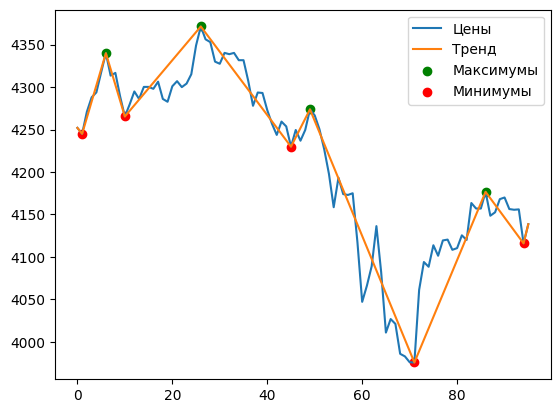

In [10]:
local_max, local_min = get_sorted_extrema(y, order=order)
y_trend, trend_power, trend_period, trend_period2end = get_trends(y, local_max, local_min)

plt.plot(y, label="Цены")
plt.plot(y_trend, label="Тренд")

# plt.plot(a, label="Тренд")
plt.scatter(local_max, y[local_max], color='g', label="Максимумы")
plt.scatter(local_min, y[local_min], color='r', label="Минимумы")
plt.legend()
plt.show()

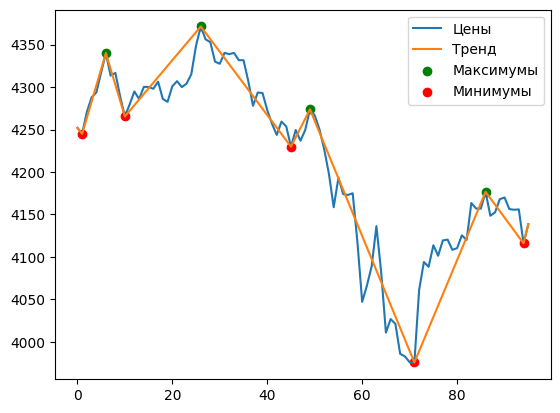

In [14]:
plt.plot(y, label="Цены")
plt.plot(y_trend, label="Тренд")
plt.scatter(local_max, y[local_max], color='g', label="Максимумы")
plt.scatter(local_min, y[local_min], color='r', label="Минимумы")
plt.legend()
plt.show()

In [378]:
import pandas as pd
from scipy.signal import argrelextrema

df2 = df[900:1150].copy()

order = 20

y = df2['close'].values
x = np.array(df2['close'].index)

# Определяем локальные экстремумы


# local_max = argrelextrema(y, comparator=np.greater, order=order, mode='clip')[0]
# local_min = argrelextrema(y, comparator=np.less, order=order, mode='clip')[0]

# plt.plot(y, label="Цены")
# plt.scatter(local_max, y[local_max], color='g', label="Максимумы")
# plt.scatter(local_min, y[local_min], color='r', label="Минимумы")
# plt.legend()
# plt.show()


In [379]:
def get_extrems(y: np.array, order: int):
    local_max = argrelextrema(y, comparator=np.greater, order=order, mode='clip')[0]
    local_min = argrelextrema(y, comparator=np.less, order=order, mode='clip')[0]

    extrems_max = pd.DataFrame(y[local_max], index=local_max, columns=['y'])
    extrems_max['sign'] = 1
    
    extrems_min = pd.DataFrame(y[local_min], index=local_min, columns=['y'])
    extrems_min['sign'] = -1
    
    extrems = pd.concat([extrems_max, extrems_min]).sort_index()
    
    extrems['group'] = (extrems['sign'] != extrems['sign'].shift()).cumsum().bfill()
    
    extrems_max = extrems[extrems['sign']==1]\
        .groupby('group',as_index=False)['y'].idxmax()\
        .rename(columns={'y':'id'})
    extrems_min = extrems[extrems['sign']==-1]\
        .groupby('group',as_index=False)['y'].idxmin()\
        .rename(columns={'y':'id'})
    
    return extrems_max['id'].values, extrems_min['id'].values

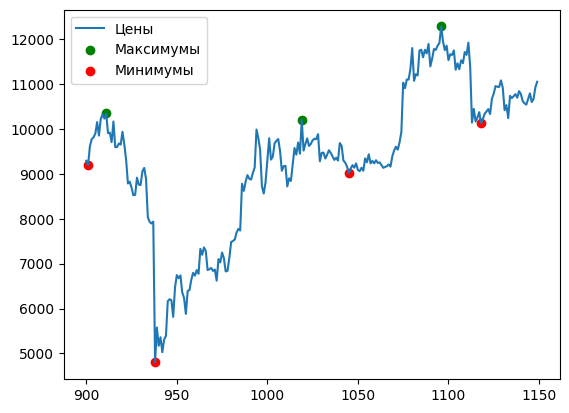

In [380]:
local_max, local_min = get_extrems(y, order=order)

plt.plot(df2['close'], label="Цены")
plt.scatter(x[local_max], y[local_max], color='g', label="Максимумы")
plt.scatter(x[local_min], y[local_min], color='r', label="Минимумы")
plt.legend()
plt.show()


In [265]:
df2['extrems'] = 0
df2['max_extrems'] = 0
df2['min_extrems'] = 0

# df2.loc[x[local_max], 'max_extrems'] = 1
# df2.loc[x[local_min], 'min_extrems'] = 1

df2.loc[x[local_max], 'extrems'] = 1
df2.loc[x[local_min], 'extrems'] = -1

extrems = df2[df2['extrems']!=0][['extrems','close']]

extrems['group'] = (extrems['extrems'] != extrems['extrems'].shift()).cumsum().bfill()

extrems_max = extrems[extrems['extrems']==1]\
    .groupby('group',as_index=False)['close'].idxmax()\
    .rename(columns={'close':'id'})
extrems_min = extrems[extrems['extrems']==-1]\
    .groupby('group',as_index=False)['close'].idxmin()\
    .rename(columns={'close':'id'})
extrems = pd.concat([extrems_max, extrems_min]).sort_values('group')

In [270]:
df2.loc[extrems_max['id'], 'max_extrems'] = 1
df2.loc[extrems_min['id'], 'min_extrems'] = 1

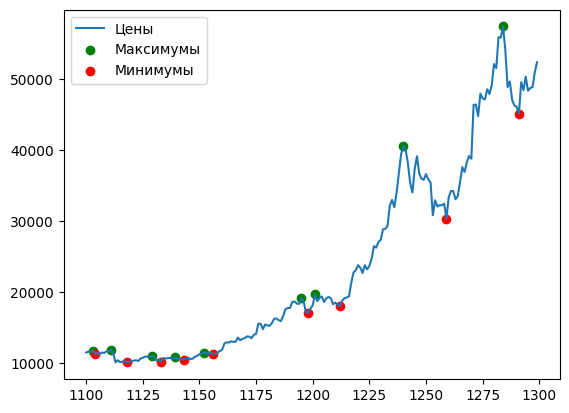

In [271]:
plt.plot(df2['close'], label="Цены")
plt.scatter(df2[df2['max_extrems']==1].index, 
            df2[df2['max_extrems']==1]['close'], 
            color='g', label="Максимумы")
plt.scatter(df2[df2['min_extrems']==1].index, 
            df2[df2['min_extrems']==1]['close'], 
            color='r', label="Минимумы")
plt.legend()
plt.show()

# scipy.find_peaks (худший способ)

In [7]:
k = 1
y = df[96*k: 96*(k+1)]['close'].values
x = np.arange(0,len(y))

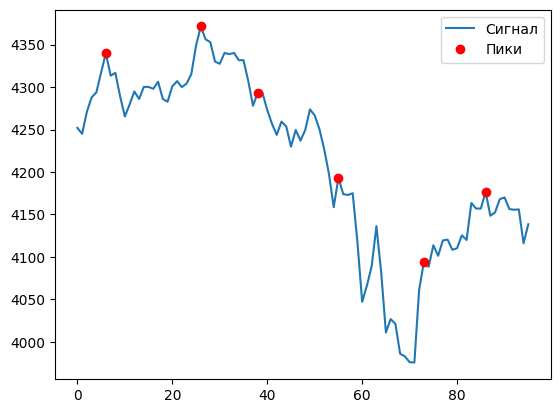

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# # Генерируем искусственный временной ряд
# x = np.linspace(0, 10, 100)
# y = np.sin(x) + np.random.normal(0, 0.1, len(x))

# Определение пиков (локальных максимумов)
peaks, _ = find_peaks(y, distance=12) 

plt.plot(x, y, label="Сигнал")
plt.plot(x[peaks], y[peaks], "ro", label="Пики")
plt.legend()
plt.show()


# TaLib.MACD

In [63]:
import talib

In [358]:
df2 = df[1100:1300].copy()
# y = df[:1000]['close'].values
# x = np.arange(0,len(y))

In [359]:
fastperiod = 12
slowperiod = 26
signalperiod = 9

df2['MA_fast'] = talib.EMA(df2['close'].values, timeperiod=fastperiod)
df2['MA_fast'] = df2['MA_fast'].shift(int(-fastperiod/2))
df2['MA_slow'] = talib.EMA(df2['close'].values, timeperiod=slowperiod)
df2['MA_slow'] = df2['MA_slow'].shift(int(-slowperiod/2))

df2['macd'] = df2['MA_fast'] - df2['MA_slow']

# df2['macd'], df2['macdSignal'], df2['macdHist']= \
#     talib.MACD(df2['close'].values, 
#                fastperiod=fastperiod, 
#                slowperiod=slowperiod, 
#                signalperiod=signalperiod)

In [360]:
df2['sign_macd'] = df2['macd'].map(np.sign)
df2['sign_macd'] = df2['sign_macd'].replace(0, np.nan)
df2['sign_macd'] = df2['sign_macd'].ffill()
df2['sign_macd'] = df2['sign_macd'].bfill()

df2['group_macd'] = (df2['sign_macd'] != df2['sign_macd'].shift()).cumsum().bfill()


extrems_max = df2[df2['sign_macd']==1].groupby('group_macd',as_index=False)['close'].idxmax()\
    .rename(columns={'close':'id'})
extrems_min = df2[df2['sign_macd']==-1].groupby('group_macd',as_index=False)['close'].idxmin()\
    .rename(columns={'close':'id'})
extrems = pd.concat([extrems_max, extrems_min]).sort_values('group_macd')


In [361]:
df2['extrems'] = 0
df2['max_extrems'] = 0
df2['min_extrems'] = 0

df2.loc[extrems['id'].values, 'extrems'] = 1
df2.loc[extrems_max['id'].values, 'max_extrems'] = 1
df2.loc[extrems_min['id'].values, 'min_extrems'] = 1

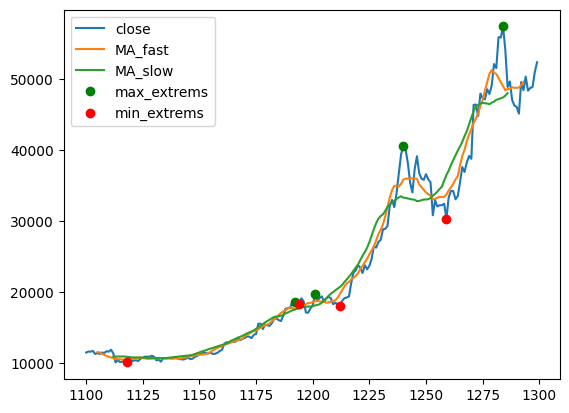

In [362]:
plt.plot(df2.index, df2['close'], label="close")
plt.plot(df2.index, df2['MA_fast'], label="MA_fast")
plt.plot(df2.index, df2['MA_slow'], label="MA_slow")
# plt.plot(df2[df2['extrems']==1]['close'].index, df2[df2['extrems']==1]['close'], 'ro', label="macdSignal")

plt.plot(df2[df2['max_extrems']==1]['close'].index, df2[df2['max_extrems']==1]['close'], 'go', label="max_extrems")
plt.plot(df2[df2['min_extrems']==1]['close'].index, df2[df2['min_extrems']==1]['close'], 'ro', label="min_extrems")
# plt.plot(df2.index, df2['macdHist'], label="macdHist")
# plt.plot(x[peaks], y[peaks], "ro", label="Пики")
plt.legend()
plt.show()

# Распределение соотношения волн (гипотеза волн элиота)

In [3]:
shift = 2
df_stat = df[df['base_extrems']!=0].copy()
df_stat['eliot_len'] =  df_stat['close'] - df_stat['close'].shift(1)
df_stat['eliot_diff_1']  = (df_stat['eliot_len'] / df_stat['eliot_len'].shift(shift)).abs()


left = 0
right = 3

plt.hist(df_stat['eliot_diff_1'], bins=100, alpha=0.7, range=[left,right])

x_ticks = np.arange(left, right, 0.1)

# Устанавливаем деления
plt.xticks(x_ticks, rotation=45)

plt.show()

NameError: name 'df' is not defined

# Линии поддержки/сопротивления

In [189]:
# points = [Point(x,y) for x,y in df1[(df1['base_extrems']!=0) & (df1['big_vol']==1)]['close'].items()]

# points = [Point(x,y) for x,y in df1[(df1['base_extrems']!=0)]['close'].items()]
# points = [Point(x,y) for x,y in df1[(df1['base_local_max']!=0)]['close'].items()]
points = [Point(x,y) for x,y in df1[(df1['base_local_min']!=0)]['close'].items()]

In [190]:
len(points)

6

In [195]:
thres_mape = 0.05

lines = []

for i in range(0, len(points)-2):
    for i2 in range(i+1, len(points)-1):
        l = Stright_line(points[i], points[i2])
        
        i_points = [i, i2]
        count_start_points = 2
        # Проверяем какие экстремумы лежат близко к заданной линии
        for j in range(i2+1,len(points)):
            mape = np.abs(l.y(points[j].x) - points[j].y) / points[j].y
            if mape <= thres_mape:
                i_points.append(j)
                
        while len(i_points) > count_start_points:
            count_start_points = len(i_points)
            l = set_mean_line([points[k] for k in i_points])
            
            i_points = []
            for j in range(0,len(points)):
                mape = np.abs(l.y(points[j].x) - points[j].y) / points[j].y
                if mape <= thres_mape:
                    i_points.append(j)
        
        if not any(is_equal_lines(l, line[0], 
                                  points[np.min(i_points + line[1])].x,
                                  points[np.max(i_points + line[1])].x, 
                                  thres_mape*2)
                   for line in lines):
            lines.append([l, i_points])

lines = sorted(lines, key=lambda t: len(t[1]), reverse=True)

In [196]:
len(lines)

6

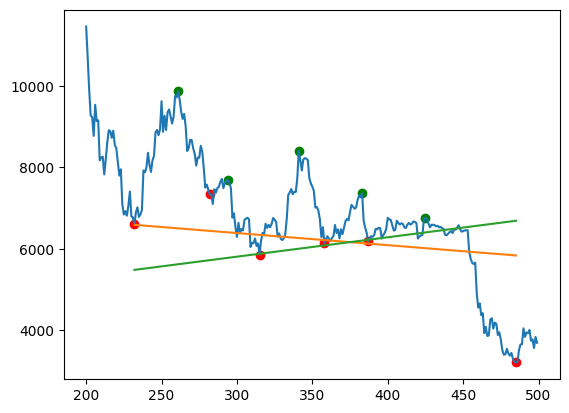

In [198]:
plt.plot(df1.index, df1['close'], label="Сигнал")
plt.scatter(df1[df1['base_local_max']==1].index, 
            df1[df1['base_local_max']==1]['close'], color='green', label="Пики")
plt.scatter(df1[df1['base_local_min']==1].index, 
            df1[df1['base_local_min']==1]['close'], color='red', label="Пики")

for i in range(len(lines)):
    if len(lines[i][1]) >= 3:
        l = lines[i][0]
        xs = [points[p].x for p in range(len(points))] # lines[i][1]
        ys = [l.y(points[p].x) for p in range(len(points))] # lines[i][1]
        plt.plot(xs, ys, label="support")
    else:
        break

plt.show()

In [143]:
d = defaultdict(list)

for l, pts in lines:
    if len(pts) >= 3:
        for p in pts:
            d[p] += [l]

In [144]:
counter_lines_in_point = list(sorted(d.items(), 
                                     key=lambda item: len(item[1]), 
                                     reverse=True))

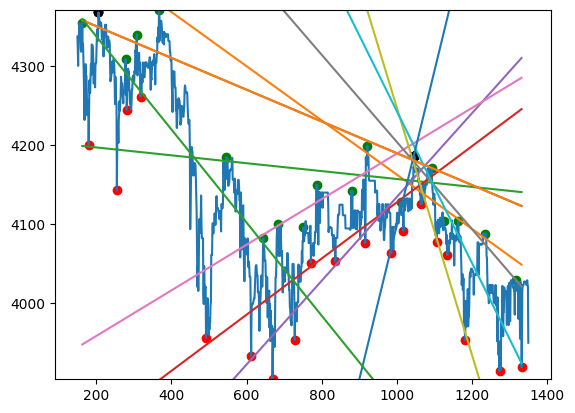

In [145]:
plt.plot(df1.index, df1['close'], label="Сигнал")
plt.scatter(df1[df1['base_local_max']==1].index, 
            df1[df1['base_local_max']==1]['close'], color='green', label="Пики")
plt.scatter(df1[df1['base_local_min']==1].index, 
            df1[df1['base_local_min']==1]['close'], color='red', label="Пики")

plt.ylim(top=df1['close'].max(), bottom=df1['close'].min())

for idx in [0,-1]: #range(0,5): #
    for l in counter_lines_in_point[idx][1]:
        plt.scatter(points[counter_lines_in_point[idx][0]].x, 
                    points[counter_lines_in_point[idx][0]].y, color='black')
        xs = [points[p].x for p in range(len(points))] # lines[i][1]
        ys = [l.y(points[p].x) for p in range(len(points))] # lines[i][1]
        plt.plot(xs, ys, label="support")

plt.show()

In [77]:
len(counter_lines_in_point)

18

In [146]:
df.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'vol', 'big_vol', 'extrems',
       'local_max', 'local_min', 'base_extrems', 'base_local_max',
       'base_local_min'],
      dtype='object')

,close
datetime,
2017-08-17,4285.08
2017-08-18,4108.37
2017-08-19,4139.98
2017-08-20,4086.29
2017-08-21,4016.00
...,...
2024-12-31,93576.00
2025-01-01,94591.79
2025-01-02,96984.79
